# Visualization of weekly summary of statistics

# Imports

In [1]:
from pathlib import Path
import datetime
import pytz
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# Functions and classes

In [2]:
class Location():
    RESOL = 30
    RULE = f"{RESOL}T"

    TS_FORMAT = '%Y-%m-%d %H:%M:%S'
    tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
    tz_paris = pytz.timezone("Europe/Paris")  # locations are in Paris, France

    # Duration of validation data
    ONE_HOUR = 60 // RESOL
    ONE_DAY = 24*ONE_HOUR
    ONE_WEEK = 7*ONE_DAY
    TWO_WEEKS = 2*ONE_WEEK
    DAYS_OF_THE_WEEK = {0: 'lundi',
                        1: 'mardi',
                        2: 'mercredi',
                        3: 'jeudi',
                        4: 'vendredi',
                        5: 'samedi',
                        6: 'dimanche'}

    LOCATIONS = {
        'moulin': {
            'name': 'moulin',
            'address': "rue du Fer à Moulin",
            'max_seats': 65,
            'color': 'xkcd:coral'
        },
        'alesia': {
            'name': 'alesia',
            'address': "rue d'Alésia",
            'max_seats': 82,
            'color': 'xkcd:cerulean'
        },
        'marcadet': {
            'name': 'marcadet',
            'address': "rue Marcadet",
            'max_seats': 55,
            'color': 'xkcd:dark teal'
        }
    }
    
    @staticmethod
    def validate_timestamp_format(date_text):
        try:
            if date_text != datetime.datetime.strptime(date_text, Location.TS_FORMAT).strftime(Location.TS_FORMAT):
                raise ValueError
            return True
        except ValueError:
            return False

    @staticmethod
    def add_temporal_features(data):
        """Add temporal features to dataframe `data`.
        """
        data['Date'] = \
            data['timestamp'].apply(
                lambda dt: dt.replace(hour=0, minute=0, second=0)
            )
    
        attributes = \
            ['Minute', 'Hour', 'Day', 'DayOfWeek', 'WeekOfYear', 'DayOfYear', 'Month']
        for attr in attributes:
            data[attr] = getattr(data['timestamp'].dt, attr.lower())
    
        data['WeekOf'] = data['Date'] - data['DayOfWeek']*pd.Timedelta(days=1)
    
        data['MinuteOfDay'] = 60*data['Hour'] + data['Minute']
    
        data['MinuteOfWeek'] = 24*60*data['DayOfWeek'] + data['MinuteOfDay']
    
        for col in ['Date', 'WeekOf']:
            data[col] = pd.to_datetime(data[col].dt.date)
    
    @staticmethod
    def extract_data(name, raw):
        print(f"Extracting data for location {name}.")
#         raw = raw[-10_000:].copy()
        # Rename column to `seats`
        data = raw[['timestamp', name]].copy()
        data.rename(columns={name: 'seats'}, inplace=True)
    
        # Missing values
        print(f"Removing missing values ({data.isna().sum().sum()} detected)...")
        data.dropna(axis=0, how='any', inplace=True)
    
        # Duplicate timestamps
        val_count = data.timestamp.value_counts()
        print(f"Removing duplicate timestamps ({sum(val_count > 1)} detected)...")
        data.drop_duplicates(inplace=True)
    
        # Unordered timestamps
        print(f'Reorder unordered timestamps...')
        unordered_timestamps = data.timestamp.values
        ordered_timestamps = np.sort(unordered_timestamps)
        data.sort_values(by='timestamp')
    
        # Remove rows with non valid timestamps
        valid_timestamps = data.timestamp.apply(Location.validate_timestamp_format)
        print(f"Removing non valid timestamps ({(~valid_timestamps).sum()} detected)...")
        data = data[valid_timestamps]
    
        # Parse dates and convert timezones
        print("Parsing dates and converting timezones...")
        data.timestamp = data.timestamp.apply(lambda string: pd.datetime.strptime(string, Location.TS_FORMAT))
        data.timestamp = data.timestamp.apply(lambda ts: ts.tz_localize(Location.tz_utc).tz_convert(Location.tz_paris))
    
        # Time-regularization
        print("Time regularization...")
        data.set_index('timestamp', inplace=True)
        data = data.resample(Location.RULE).mean().interpolate().round().astype(np.uint8)
        data.reset_index(inplace=True)
    
        # Add temporal features
        print("Additional temporal features...")
        Location.add_temporal_features(data)
    
        print("Done.")
        return data    

    def get_past_week(self):
        data = self.data
        last_timestamp = data.timestamp.iloc[-1]
        one_week_ago = last_timestamp - pd.Timedelta('7D')
        past_week = data[data.timestamp >= one_week_ago].copy()
        past_week = [(weekofyear, past_week[past_week['WeekOfYear'] == weekofyear]) for weekofyear in np.sort(past_week['WeekOfYear'].unique())]
        return past_week
    
    def get_weekly_views(self):
        weeks = pd.pivot_table(self.data, index='MinuteOfWeek', columns='WeekOfYear', values='seats')
        return weeks
    
    def get_statistics(self):
        table = self.weeks
        statistics = table.median(axis=1).to_frame(name='median')

        percentages = np.array([.02, .2, .4])
        for p in np.hstack([percentages, np.array([1 - p for p in percentages[::-1]])]):
            statistics[f'quantile_{p:.2f}'] = table.apply(lambda row: np.nanquantile(row, p), axis=1)

        statistics.columns.name = 'statistics'
        return statistics, percentages

    def __init__(self, name, raw):
        self.name = name
        self.data = Location.extract_data(name, raw)
        self.past_week = self.get_past_week()
        self.weeks = self.get_weekly_views()
        self.statistics, self.percentages = self.get_statistics()
        
    def print_summary_across_weeks(self):
        name = self.name
        table = self.weeks
        address = Location.LOCATIONS[name]['address']

        fig, ax = plt.subplots(figsize=(16, 4))

        ax.boxplot([vals.dropna() for col, vals in table.iteritems()]);
        ax.set_xticklabels(table.columns);
        ax.set_xlabel("semaine de l'année", fontsize=14)
        ax.set_ylabel("nombre de places", fontsize=14)
        ax.set_title(f"Disponibilité de la {address}", fontsize=22);
        
    def print_weekly_summary(self):
        name = self.name
        address = Location.LOCATIONS[name]['address']
        max_seats = Location.LOCATIONS[name]['max_seats']
        color_statistics = Location.LOCATIONS[name]['color']

        color_past_week = 'k'
        timestamp_format = '%d %b %Y %Hh%M'
        
        past_week = self.past_week
        statistics = self.statistics
        percentages = self.percentages


        fig, axs = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

        suptitlestring = f"Disponibilité de la {address}"
        fig.suptitle(suptitlestring, fontsize=26, y=.95);

        for i, (weekofyear, df) in enumerate(past_week):
            ax = axs[i]
            df.plot(x='MinuteOfWeek', y='seats', ax=ax, color=color_past_week, linewidth=4)
            if ((len(past_week) == 2) & (i == 1)) | (len(past_week) == 1):
                minuteofweek = df.MinuteOfWeek.iloc[-1]
                horizontalalignment = 'right' if minuteofweek > 60*24*7/2 else 'left'
                horizontaldisplacement = 2*60
                if horizontalalignment == 'right':
                    horizontaldisplacement = - horizontaldisplacement

                ax.axvline(minuteofweek, linestyle='--', color='k')
                ax.text(
                    minuteofweek + horizontaldisplacement,
                    max_seats -2,
                    df.timestamp.iloc[-1].strftime(timestamp_format),
                    verticalalignment='top',
                    horizontalalignment=horizontalalignment,
                    fontsize=14
                )



        for i in range(2):
            ax = axs[i]
            ax.plot(statistics.index, statistics['median'], color=color_statistics, linewidth=2, alpha=.8)
            ax.set_xlim([0, 60*24*7])
            ax.set_ylim(0, 10*(max_seats//10 + 1));

            for p in percentages:
                ax.fill_between(statistics.index, statistics[f'quantile_{p:.2f}'], statistics[f'quantile_{1-p:.2f}'], alpha=np.sqrt(p), facecolor=color_statistics)
            ax.grid();

            ax.set_ylabel('nombre de places', fontsize=14)
            ax.axhline(max_seats, color=color_statistics, linestyle='--', linewidth=2)

            # Ticks and labels for days of week
            ax.xaxis.set_major_locator(ticker.FixedLocator([12*60 + i*24*60 for i in range(7)]))
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: Location.DAYS_OF_THE_WEEK[(x - 12*60) // (24*60)]))
            ax.tick_params(axis='x', which='major', pad=10, length=0)

            # Ticks and labels for time of day
            nb_hours = 24
            ax.xaxis.set_minor_locator(ticker.MultipleLocator(60*nb_hours))
            # ax.xaxis.set_minor_formatter(ticker.FuncFormatter(lambda x, pos: f"{x % 60*nb_hours:.0f}h"))
            ax.tick_params(axis='x', which='minor', grid_color='k', grid_alpha=.5, length=14, labelrotation=45)
            ax.grid(b=True, which='minor', axis='x')

            ax.xaxis.set_label_text("")


            if i == 0:
                first_timestamp = past_week[0][1].timestamp.iloc[0]
                last_timestamp = past_week[1][1].timestamp.iloc[-1]

                ax.set_title(
                    f"Tendances historiques et données du {first_timestamp.strftime(timestamp_format)} au {last_timestamp.strftime(timestamp_format)}",
                    fontsize=18
                )


            # Ticks and labels on y-axis
            ax.set_yticks(np.append(ax.get_yticks(), [max_seats]))
            ax.set_yticklabels([int(y)
                                if y != max_seats
                                else f"max: {int(y)}"
                                for y in ax.get_yticks()
                               ]);


            ax.legend().remove()

# Load dataset

In [3]:
path = Path.home()/'Data'/'la_permanence'/'availability.csv'
raw = pd.read_csv(path)

# Initializing Location objects for all three locations

In [4]:
moulin = Location('moulin', raw)
alesia = Location('alesia', raw)
marcadet = Location('marcadet', raw)

Extracting data for location moulin.
Removing missing values (1 detected)...
Removing duplicate timestamps (2 detected)...
Reorder unordered timestamps...
Removing non valid timestamps (0 detected)...
Parsing dates and converting timezones...
Time regularization...
Additional temporal features...
Done.
Extracting data for location alesia.
Removing missing values (1 detected)...
Removing duplicate timestamps (2 detected)...
Reorder unordered timestamps...
Removing non valid timestamps (0 detected)...
Parsing dates and converting timezones...
Time regularization...
Additional temporal features...
Done.
Extracting data for location marcadet.
Removing missing values (164499 detected)...
Removing duplicate timestamps (1 detected)...
Reorder unordered timestamps...
Removing non valid timestamps (0 detected)...
Parsing dates and converting timezones...
Time regularization...
Additional temporal features...
Done.


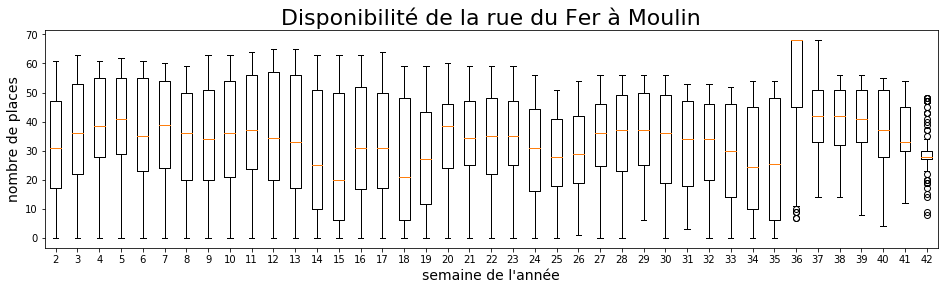

In [5]:
moulin.print_summary_across_weeks()

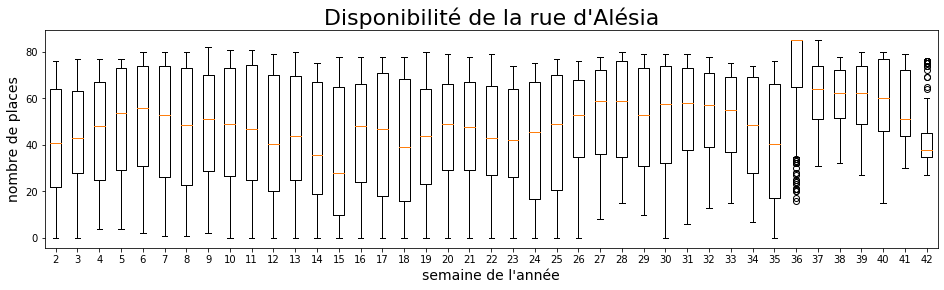

In [6]:
alesia.print_summary_across_weeks()

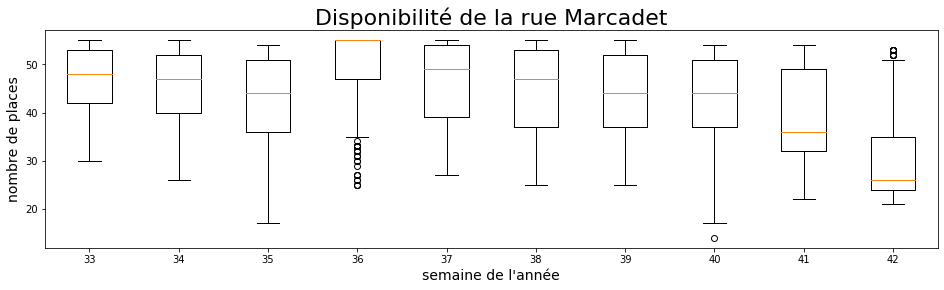

In [7]:
marcadet.print_summary_across_weeks()

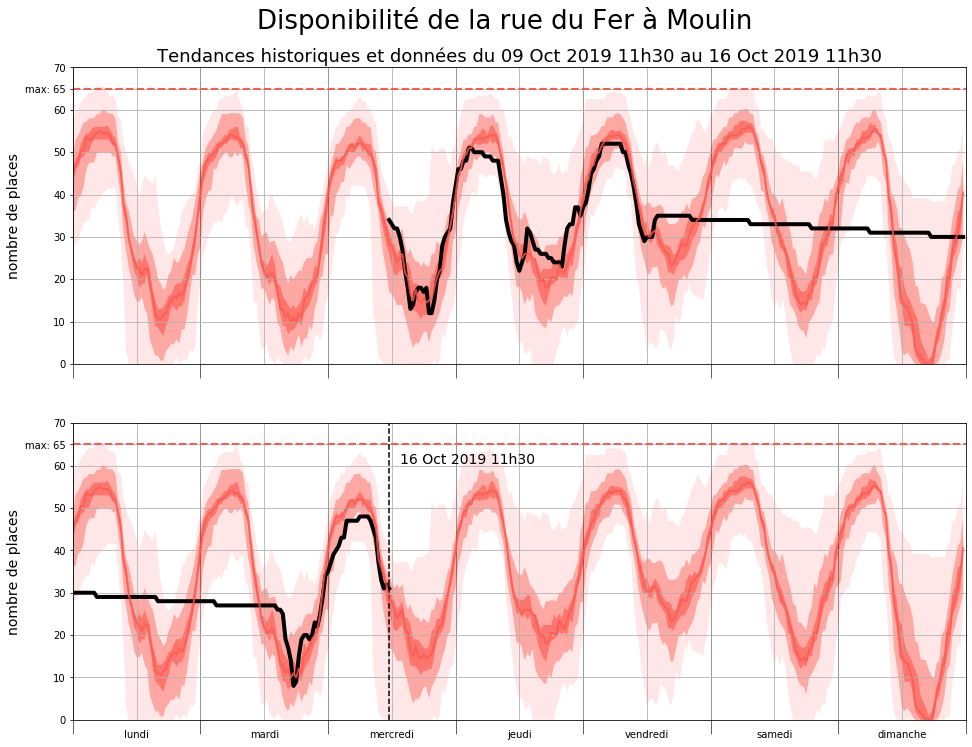

In [8]:
moulin.print_weekly_summary()

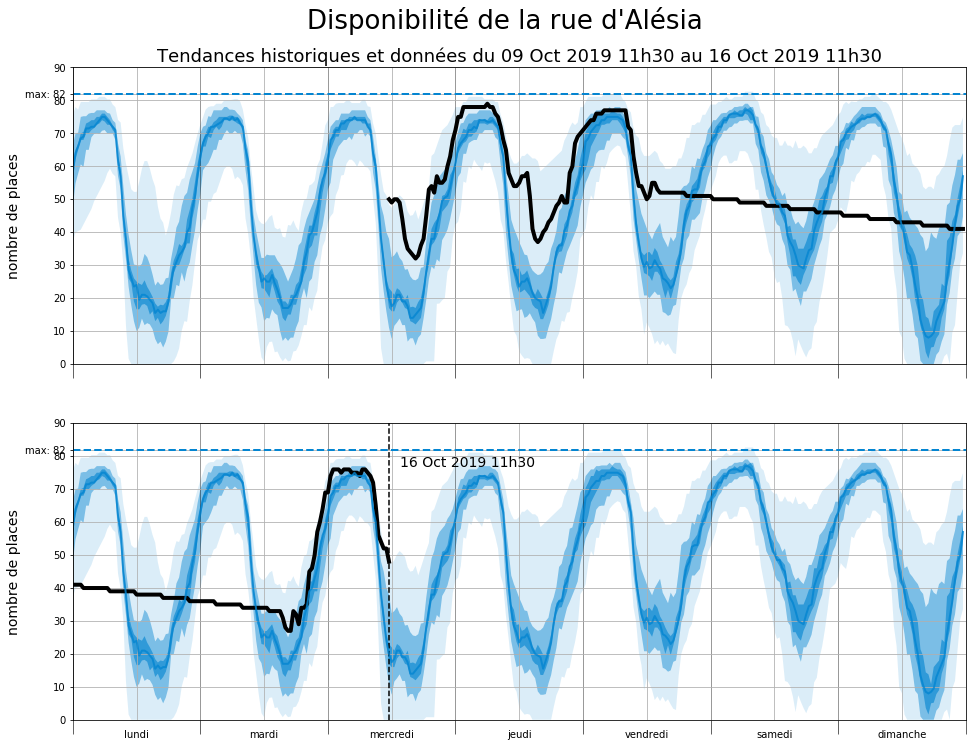

In [9]:
alesia.print_weekly_summary()

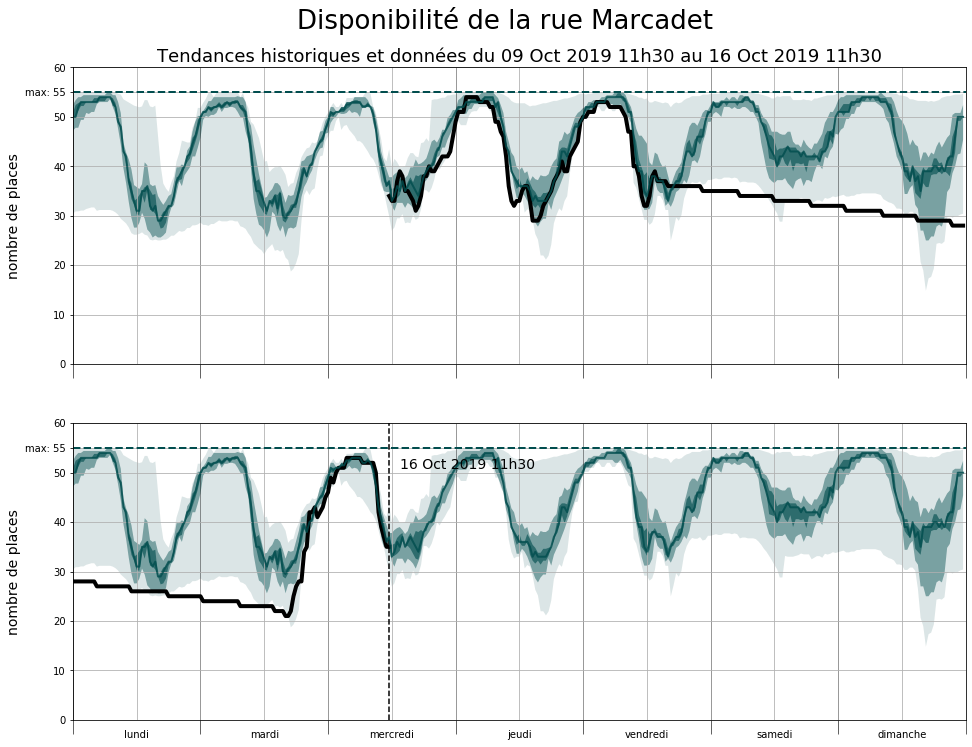

In [10]:
marcadet.print_weekly_summary()